Import Library yang Dibutuhkan

In [1]:
# Import Library yang akan digunakan

import pandas as pd
import nltk, os, re, string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding, Flatten, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
import csv
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load Dataset

In [2]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/karlinasuryaw/moviesentiment/main/data14k_new.csv')
dataframe.head(11)

,Unnamed: 0,title,review,score
0,0,10 Cloverfield Lane 2016\n,This movie is full of suspense. It makes you g...,0
1,1,10 Cloverfield Lane 2016\n,I'll leave this review fairly concise. <br/><b...,0
2,2,10 Cloverfield Lane 2016\n,I give the 5/10 out of the credit I owe to the...,0
3,3,10 Cloverfield Lane 2016\n,"First of all, I must say that I was expecting ...",0
4,4,10 Cloverfield Lane 2016\n,I never write reviews. ever. This is probably ...,0
5,5,10 Cloverfield Lane 2016\n,"Goodman plays Howard, a paranoid psychopath an...",0
6,6,10 Cloverfield Lane 2016\n,Many movie lovers will leave this film with a ...,0
7,7,10 Cloverfield Lane 2016\n,Awful does not even begin to describe this mes...,0
8,8,10 Cloverfield Lane 2016\n,I loved Cloverfield which for me was one of th...,0
9,9,10 Cloverfield Lane 2016\n,May contain spoilers so read at your own risk....,0


Menghitung Jumlah Data Berdasarkan Judul Film

In [3]:
dataframe.title.value_counts()

Dunkirk 2017                              90
Uri The Surgical Strike 2019              90
Spectre 2015                              90
Southpaw 2015                             90
Spider-Man Into the Spider-Verse 2018     90
                                          ..
Youth 2015                                58
Little Boy 2015                           58
Popstar Never Stop Never Stopping 2016    55
M.S. Dhoni The Untold Story 2016          52
Sing Street 2016                          50
Name: title, Length: 165, dtype: int64

Menghapus kolom yang tidak digunakan

In [4]:
dataframe = dataframe.drop(columns = ['Unnamed: 0'])
dataframe.head(11)

,title,review,score
0,10 Cloverfield Lane 2016\n,This movie is full of suspense. It makes you g...,0
1,10 Cloverfield Lane 2016\n,I'll leave this review fairly concise. <br/><b...,0
2,10 Cloverfield Lane 2016\n,I give the 5/10 out of the credit I owe to the...,0
3,10 Cloverfield Lane 2016\n,"First of all, I must say that I was expecting ...",0
4,10 Cloverfield Lane 2016\n,I never write reviews. ever. This is probably ...,0
5,10 Cloverfield Lane 2016\n,"Goodman plays Howard, a paranoid psychopath an...",0
6,10 Cloverfield Lane 2016\n,Many movie lovers will leave this film with a ...,0
7,10 Cloverfield Lane 2016\n,Awful does not even begin to describe this mes...,0
8,10 Cloverfield Lane 2016\n,I loved Cloverfield which for me was one of th...,0
9,10 Cloverfield Lane 2016\n,May contain spoilers so read at your own risk....,0


In [5]:
# Total data

dataframe.shape

(14000, 3)

Menghitung Jumlah Data per Kategori Sentimen (Sentimen Positif score 1 & Sentimen Negatif Score 0)

In [6]:
dataframe.groupby(['score']).count()

,title,review
score,,
0,7000,7000
1,7000,7000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='score', ylabel='count'>

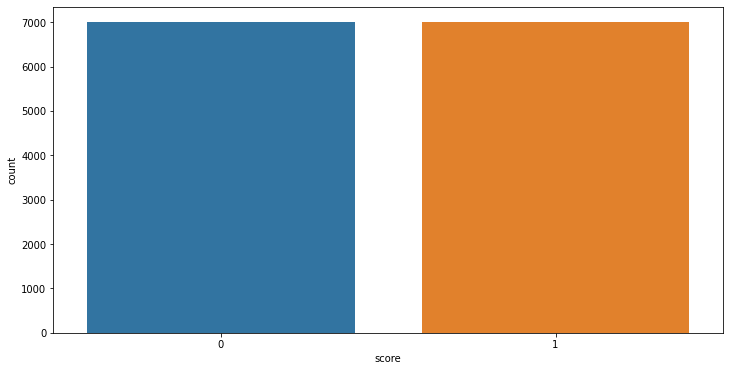

In [7]:
plt.figure(figsize = (12, 6))
sns.countplot(dataframe.score)

Text Preprocessing

Lowercase

In [8]:
dataframe.title = dataframe.title.apply(lambda x: x.lower())
dataframe.review = dataframe.review.apply(lambda x: x.lower())


Data Cleansing

In [9]:
dataframe.head(11)

,title,review,score
0,10 cloverfield lane 2016\n,this movie is full of suspense. it makes you g...,0
1,10 cloverfield lane 2016\n,i'll leave this review fairly concise. <br/><b...,0
2,10 cloverfield lane 2016\n,i give the 5/10 out of the credit i owe to the...,0
3,10 cloverfield lane 2016\n,"first of all, i must say that i was expecting ...",0
4,10 cloverfield lane 2016\n,i never write reviews. ever. this is probably ...,0
5,10 cloverfield lane 2016\n,"goodman plays howard, a paranoid psychopath an...",0
6,10 cloverfield lane 2016\n,many movie lovers will leave this film with a ...,0
7,10 cloverfield lane 2016\n,awful does not even begin to describe this mes...,0
8,10 cloverfield lane 2016\n,i loved cloverfield which for me was one of th...,0
9,10 cloverfield lane 2016\n,may contain spoilers so read at your own risk....,0


In [10]:
#menghapus tanda baca
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
dataframe.title = dataframe.title.apply(lambda x: cleaner(x))
dataframe.review = dataframe.review.apply(lambda x: cleaner(x))


In [11]:
dataframe.head(11)

,title,review,score
0,10 cloverfield lane 2016\n,this movie is full of suspense it makes you gu...,0
1,10 cloverfield lane 2016\n,ill leave this review fairly concise brbrthis ...,0
2,10 cloverfield lane 2016\n,i give the 510 out of the credit i owe to the ...,0
3,10 cloverfield lane 2016\n,first of all i must say that i was expecting s...,0
4,10 cloverfield lane 2016\n,i never write reviews ever this is probably my...,0
5,10 cloverfield lane 2016\n,goodman plays howard a paranoid psychopath and...,0
6,10 cloverfield lane 2016\n,many movie lovers will leave this film with a ...,0
7,10 cloverfield lane 2016\n,awful does not even begin to describe this mes...,0
8,10 cloverfield lane 2016\n,i loved cloverfield which for me was one of th...,0
9,10 cloverfield lane 2016\n,may contain spoilers so read at your own riskb...,0


Stopword Removal

In [12]:
stwrds = stopwords.words('english')
def stopword(data):
    return(' '.join([w for w in data.split() if w not in stwrds ]))
dataframe.title = dataframe.title.apply(lambda x: stopword(x))
dataframe.review = dataframe.review.apply(lambda x: stopword(x))


In [13]:
dataframe.head(11)

,title,review,score
0,10 cloverfield lane 2016,movie full suspense makes guess real happens w...,0
1,10 cloverfield lane 2016,ill leave review fairly concise brbrthis film ...,0
2,10 cloverfield lane 2016,give 510 credit owe original writers fascinati...,0
3,10 cloverfield lane 2016,first must say expecting something different c...,0
4,10 cloverfield lane 2016,never write reviews ever probably first everbr...,0
5,10 cloverfield lane 2016,goodman plays howard paranoid psychopath propr...,0
6,10 cloverfield lane 2016,many movie lovers leave film dilemma swirling ...,0
7,10 cloverfield lane 2016,awful even begin describe mess movie absolutel...,0
8,10 cloverfield lane 2016,loved cloverfield one best films 21st century ...,0
9,10 cloverfield lane 2016,may contain spoilers read riskbrbrpretty much ...,0


#### remove number

In [14]:
dataframe['review'] = dataframe['review'].str.replace(r'\d+','')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [15]:
dataframe.head(11)

,title,review,score
0,10 cloverfield lane 2016,movie full suspense makes guess real happens w...,0
1,10 cloverfield lane 2016,ill leave review fairly concise brbrthis film ...,0
2,10 cloverfield lane 2016,give credit owe original writers fascinating ...,0
3,10 cloverfield lane 2016,first must say expecting something different c...,0
4,10 cloverfield lane 2016,never write reviews ever probably first everbr...,0
5,10 cloverfield lane 2016,goodman plays howard paranoid psychopath propr...,0
6,10 cloverfield lane 2016,many movie lovers leave film dilemma swirling ...,0
7,10 cloverfield lane 2016,awful even begin describe mess movie absolutel...,0
8,10 cloverfield lane 2016,loved cloverfield one best films st century sa...,0
9,10 cloverfield lane 2016,may contain spoilers read riskbrbrpretty much ...,0


In [16]:
X = dataframe['review']
y = dataframe["score"]
y = to_categorical(y)

Merubah text menjadi sequences of number dan Menentukan Jumlah vocab

In [17]:
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold


In [18]:
#jml_vocab = len(tokenizer.index_word)+1


In [19]:
jumlah_vocab = 10000
output_dim = 300

In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token='OOV')
tokenizer.fit_on_texts(X)

In [21]:
sequence_text = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequence_text)

In [22]:
print(tokenizer.texts_to_sequences(['I love this movie']))
print(tokenizer.texts_to_sequences(['I hate the actor of this movie']))

[[1, 45, 1, 2]]
[[1, 486, 1, 206, 1, 1, 2]]


Split data 90% 10%

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
# Storing the average of all predictions

data_kfold = pd.DataFrame()



# k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

batch_size_tes=[32, 64, 128, 256]

# Variable for keeping count of split we are executing
j = 0
for batch in batch_size_tes:
  # K-fold Train and test for each split
  globals()['data_kfold_batch%s'%batch] =  pd.DataFrame()
  globals()['jumlah_fold_batch%s'%batch] =  pd.DataFrame()
  for train, test in kfold.split(X_train, y_train):
      
      X_train_fold, X_test_fold = X_train[train], X_train[test]
      y_train_fold, y_test_fold = y_train[train], y_train[test]
          
      j+=1
      globals()['jumlah_fold_batch%s'%batch][j] = [len(train), len(test)] 

      globals()['model_fold_%s' %batch] = tf.keras.Sequential([
          Embedding(jumlah_vocab, output_dim),
          SpatialDropout1D(0.5),
          LSTM(32, return_sequences=True),
          LSTM(32, kernel_regularizer=(tf.keras.regularizers.L2(1e-3)), recurrent_regularizer=(tf.keras.regularizers.L2(1e-3))),
          Dense(8, activation='relu'),
          Dropout(0.5),
          Dense(2, activation='sigmoid')
      ])

      globals()['model_fold_%s' %batch].compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

      globals()['model_fold_%s' %batch].summary()
      

      globals()['model_fold_%s' %batch].fit(
          X_train_fold,
          y_train_fold,
          batch_size=batch,
          epochs=5,
          validation_data=(X_test_fold, y_test_fold)
          
          ) 
          
      
      predicted_class_indices = globals()['model_fold_%s' %batch].evaluate(X_test_fold,y_test_fold)
      globals()['data_kfold_batch%s'%batch][j] = predicted_class_indices


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          42624     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [26]:
for batch in batch_size_tes:
    print(globals()['jumlah_fold_batch%s'%batch])

       1      2      3      4      5
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      6      7      8      9      10
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      11     12     13     14     15
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      16     17     18     19     20
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520


In [27]:
data_kfold_batch32

,1,2,3,4,5
0,0.591977,0.811347,0.69236,0.689747,0.629830
1,0.773810,0.756349,0.72619,0.751587,0.753968


In [28]:
data_kfold_batch64

,6,7,8,9,10
0,0.593605,0.616317,0.594246,0.772862,0.692037
1,0.786111,0.776587,0.775794,0.763889,0.761111


In [29]:
data_kfold_batch128

,11,12,13,14,15
0,0.510253,0.664517,0.568006,0.648784,0.556022
1,0.752381,0.775000,0.769444,0.761508,0.782937


In [30]:
data_kfold_batch256

,16,17,18,19,20
0,0.510352,0.555676,0.583625,0.550933,0.603368
1,0.782540,0.767857,0.759127,0.763889,0.771032


In [31]:
data_eval_kfold = pd.DataFrame()

for batch in batch_size_tes:
    print(globals()['data_kfold_batch%s'%batch].mean(axis=1))


0    0.683052
1    0.752381
dtype: float64
0    0.653813
1    0.772698
dtype: float64
0    0.589516
1    0.768254
dtype: float64
0    0.560791
1    0.768889
dtype: float64


In [33]:
# Storing the average of all predictions

data_kfold = pd.DataFrame()

# k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

epoh_tes=[3, 5, 10, 15, 20]

# Variable for keeping count of split we are executing
j = 0
for epoh in epoh_tes:
  # K-fold Train and test for each split
  globals()['data_kfold_epoh%s'%epoh] =  pd.DataFrame()
  globals()['jumlah_fold_epoh%s'%epoh]=  pd.DataFrame()

  for train, test in kfold.split(X_train, y_train):
      
      X_train_fold, X_test_fold = X_train[train], X_train[test]
      y_train_fold, y_test_fold = y_train[train], y_train[test]
          


      
      j+=1

      globals()['jumlah_fold_epoh%s'%epoh][j] = [len(train), len(test)] 
        
      globals()['model_fold_%s' %epoh] = tf.keras.Sequential([
          Embedding(jumlah_vocab, output_dim),
          SpatialDropout1D(0.5),
          LSTM(32, return_sequences=True),
          LSTM(32, kernel_regularizer=(tf.keras.regularizers.L2(1e-3)), recurrent_regularizer=(tf.keras.regularizers.L2(1e-3))),
          Dense(8, activation='relu'),
          Dropout(0.5),
          Dense(2, activation='sigmoid')
      ])

      globals()['model_fold_%s' %epoh].compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

      globals()['model_fold_%s' %epoh].summary()
      

      globals()['model_fold_%s' %epoh].fit(
          X_train_fold,
          y_train_fold,
          batch_size=64,
          epochs=epoh,
          validation_data=(X_test_fold, y_test_fold)
          ) 
 
      
      predicted_class_indices = globals()['model_fold_%s' %epoh].evaluate(X_test_fold,y_test_fold)

      globals()['data_kfold_epoh%s'%epoh][j] = predicted_class_indices


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, None, 300)         0         
_________________________________________________________________
lstm_44 (LSTM)               (None, None, 32)          42624     
_________________________________________________________________
lstm_45 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_22 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)               

In [34]:
for batch in batch_size_tes:
    print(globals()['jumlah_fold_epoh%s'%epoh])

      21     22     23     24     25
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      21     22     23     24     25
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      21     22     23     24     25
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520
      21     22     23     24     25
0  10080  10080  10080  10080  10080
1   2520   2520   2520   2520   2520


In [35]:
data_kfold_epoh3

,1,2,3,4,5
0,0.465204,0.524283,0.550929,0.513598,0.514568
1,0.793651,0.753968,0.764683,0.774206,0.756746


In [37]:
data_kfold_epoh5

,6,7,8,9,10
0,0.542305,0.669797,0.672750,0.682224,0.659090
1,0.759524,0.768651,0.768651,0.758730,0.777778


In [36]:
data_kfold_epoh10

,11,12,13,14,15
0,0.814941,0.973438,0.944199,1.100847,1.167115
1,0.722619,0.757143,0.736905,0.743254,0.748810


In [38]:
data_kfold_epoh15

,16,17,18,19,20
0,1.210067,1.833547,1.576970,1.310668,1.280933
1,0.738889,0.740079,0.741667,0.721825,0.751984


In [39]:
data_kfold_epoh20

,21,22,23,24,25
0,1.663263,1.533106,1.803321,1.263175,1.688911
1,0.742063,0.734921,0.736905,0.739286,0.751587


nilai rata rata akurasi dan loss

In [40]:
data_eval_kfold = pd.DataFrame()

for epoh in epoh_tes:
    print(globals()['data_kfold_epoh%s'%epoh].mean(axis=1))


0    0.513716
1    0.768651
dtype: float64
0    0.645233
1    0.766667
dtype: float64
0    1.000108
1    0.741746
dtype: float64
0    1.442437
1    0.738889
dtype: float64
0    1.590355
1    0.740952
dtype: float64


evaluasi model optimal dari epoch

In [41]:
#evaluasi model optimal dan simpan model ke format h5

for epoh in epoh_tes:
    globals()['model_fold_%s' %epoh].evaluate(X_test,y_test)
    globals()['model_fold_%s' %epoh].save("modelfold%s.h5"%epoh)

44/44 [==============================] - 1s 29ms/step - loss: 1.6116 - accuracy: 0.7571


In [42]:
from sklearn.metrics import classification_report, confusion_matrix


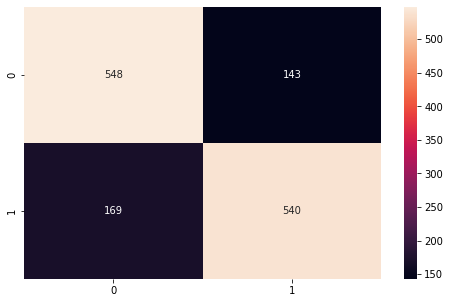

In [43]:
y_pred = model_fold_5.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
"""plt.xlabel("y_head")
plt.ylabel("y_true")"""
plt.show()

In [44]:
report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=['negative','positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.79      0.78       691
    positive       0.79      0.76      0.78       709

    accuracy                           0.78      1400
   macro avg       0.78      0.78      0.78      1400
weighted avg       0.78      0.78      0.78      1400



Simpan Tokenizer

In [45]:
import pickle

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [46]:
from keras.models import load_model

loaded_model = load_model("./modelfold5.h5")
loss, accuracy = loaded_model.evaluate(X_test, y_test)

44/44 [==============================] - 2s 25ms/step - loss: 0.6296 - accuracy: 0.7771
